# Graph Attention Networks

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import numpy as np
np.random.seed(0)

A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

In [3]:
X = np.random.uniform(-1, 1, (4, 4))
X

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ]])

In [4]:
W = np.random.uniform(-1, 1, (2, 4))
W

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

In [5]:
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.76345115,  0.27984204, -0.71329343,  0.88933783]])

In [6]:
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [7]:
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [8]:
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T
a

array([[-0.1007035 , -0.35942847,  0.96036209,  0.50390318, -0.43956122,
        -0.69828618,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [9]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318, -0.08791224,
        -0.13965724,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [10]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318],
       [-0.08791224, -0.13965724,  0.        ,  0.        ],
       [ 0.79964181,  0.        ,  1.8607074 ,  1.40424849],
       [ 0.64260322,  0.        ,  1.70366881,  1.2472099 ]])

In [11]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
W_alpha

array([[0.15862414, 0.15062488, 0.42285965, 0.26789133],
       [0.24193418, 0.22973368, 0.26416607, 0.26416607],
       [0.16208847, 0.07285714, 0.46834625, 0.29670814],
       [0.16010498, 0.08420266, 0.46261506, 0.2930773 ]])

In [12]:
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.10126376,  1.99749693],
       [-0.33950544,  0.97045933],
       [-1.03570438,  1.53614075],
       [-1.03570438,  1.53614075]])

In [4]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

Processing...
Done!


In [5]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.96 | Val Acc: 11.80%


Epoch  20 | Train Loss: 0.259 | Train Acc: 96.43% | Val Loss: 1.10 | Val Acc: 67.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 98.57% | Val Loss: 0.90 | Val Acc: 70.80%
Epoch  60 | Train Loss: 0.205 | Train Acc: 98.57% | Val Loss: 0.96 | Val Acc: 69.00%
Epoch  80 | Train Loss: 0.130 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 70.80%
Epoch 100 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.00%
GAT test accuracy: 82.00%


In [6]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

<BarContainer object of 32 artists>

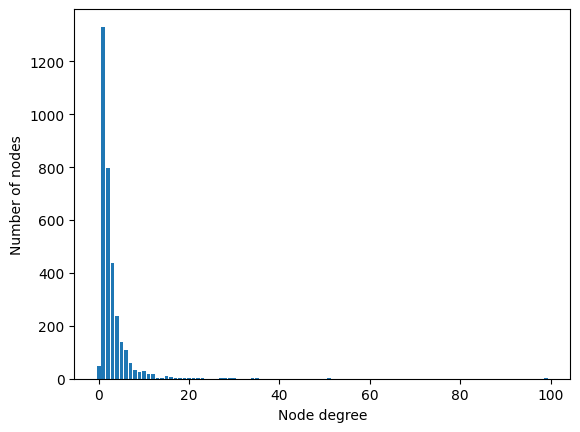

In [7]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [17]:
# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Epoch   0 | Train Loss: 1.803 | Train Acc: 15.83% | Val Loss: 1.81 | Val Acc: 16.60%


Epoch  20 | Train Loss: 0.175 | Train Acc: 96.67% | Val Loss: 1.15 | Val Acc: 60.40%
Epoch  40 | Train Loss: 0.134 | Train Acc: 97.50% | Val Loss: 1.22 | Val Acc: 62.00%
Epoch  60 | Train Loss: 0.135 | Train Acc: 97.50% | Val Loss: 1.21 | Val Acc: 61.60%
Epoch  80 | Train Loss: 0.111 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 63.60%
Epoch 100 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 1.24 | Val Acc: 58.60%
GAT test accuracy: 67.40%


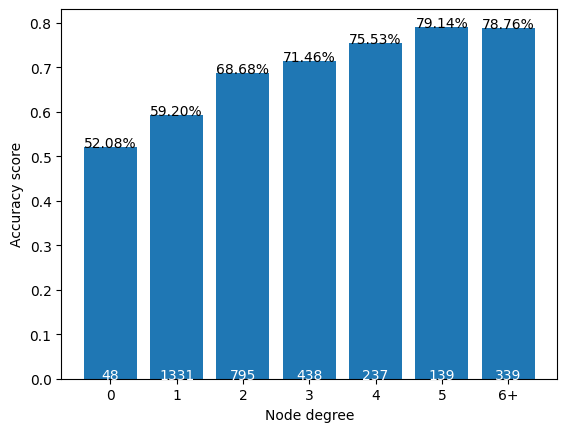

In [18]:
# Get model's classifications
out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

# Cải tiến Hiệu suất Mô hình Graph Attention Networks (GAT)

Training GATv2...
Epoch 1: Train Loss = 3.4726, Val Loss = 3.1754


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2: Train Loss = 2.1113, Val Loss = 2.8364
Epoch 3: Train Loss = 2.2290, Val Loss = 3.0151
Epoch 4: Train Loss = 1.8987, Val Loss = 2.6064
Epoch 5: Train Loss = 1.7893, Val Loss = 2.4506
Epoch 6: Train Loss = 1.4290, Val Loss = 2.3703
Epoch 7: Train Loss = 1.6148, Val Loss = 2.2822
Epoch 8: Train Loss = 1.1198, Val Loss = 2.3097
Epoch 9: Train Loss = 0.9141, Val Loss = 2.0963
Epoch 10: Train Loss = 1.1565, Val Loss = 2.2813
Epoch 11: Train Loss = 1.1963, Val Loss = 1.9386
Epoch 12: Train Loss = 0.6868, Val Loss = 1.9825
Epoch 13: Train Loss = 0.7216, Val Loss = 1.6992
Epoch 14: Train Loss = 0.6982, Val Loss = 1.9855
Epoch 15: Train Loss = 0.7981, Val Loss = 1.8228
Epoch 16: Train Loss = 0.7413, Val Loss = 1.8790
Epoch 17: Train Loss = 0.5102, Val Loss = 1.8340
Epoch 18: Train Loss = 0.4734, Val Loss = 1.6785
Epoch 19: Train Loss = 0.5459, Val Loss = 1.6284
Epoch 20: Train Loss = 0.5307, Val Loss = 2.0632
Epoch 21: Train Loss = 0.3960, Val Loss = 1.6833
Epoch 22: Train Loss = 0.333

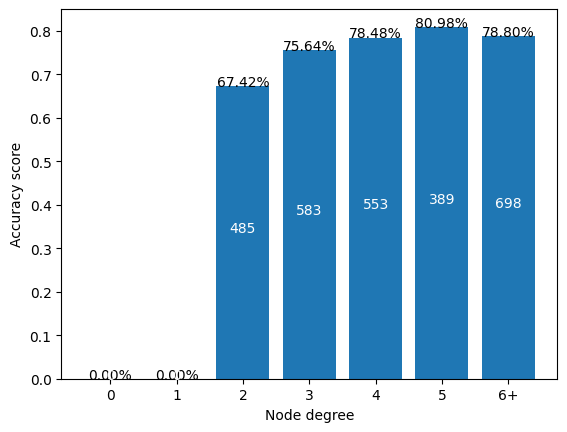

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import degree, add_self_loops
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset (Cora)
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Chuẩn hóa đặc trưng đầu vào
scaler = StandardScaler()
data.x = torch.tensor(scaler.fit_transform(data.x.numpy()), dtype=torch.float)

# Thêm self-loops vào đồ thị
data.edge_index, _ = add_self_loops(data.edge_index)


# ------------- MÔ HÌNH GATv2 ----------------
class GATv2Model(nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_h, heads=heads)
        self.gat3 = GATv2Conv(dim_h * heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat3(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs=100, lr=0.005, weight_decay=0.0005):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

        best_val_loss = float('inf')
        early_stop_patience = 10
        no_improve_count = 0

        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}: Train Loss = {loss:.4f}, Val Loss = {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= early_stop_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = (out.argmax(dim=1)[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        return acc


# ------------- HUẤN LUYỆN MÔ HÌNH ----------------
dim_in = dataset.num_features
dim_h = 32
dim_out = dataset.num_classes

gat = GATv2Model(dim_in, dim_h, dim_out)

print("Training GATv2...")
gat.fit(data, epochs=100)

# ------------- KIỂM TRA HIỆU SUẤT ----------------
test_acc = gat.test(data)
print(f"GATv2 Test Accuracy: {test_acc * 100:.2f}%")

# ------------- VẼ BIỂU ĐỒ ĐỘ CHÍNH XÁC THEO NODE DEGREE ----------------
out = gat(data.x, data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes = []

for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    if len(mask) > 0:
        acc = (out.argmax(dim=1)[mask] == data.y[mask]).sum().item() / len(mask)
        accuracies.append(acc)
        sizes.append(len(mask))
    else:
        accuracies.append(0)
        sizes.append(0)

mask = np.where(degrees > 5)[0]
if len(mask) > 0:
    acc = (out.argmax(dim=1)[mask] == data.y[mask]).sum().item() / len(mask)
    accuracies.append(acc)
    sizes.append(len(mask))

# Vẽ biểu đồ
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0', '1', '2', '3', '4', '5', '6+'], accuracies)

for i in range(len(accuracies)):
    plt.text(i, accuracies[i], f'{accuracies[i] * 100:.2f}%', ha='center', color='black')
    plt.text(i, accuracies[i] / 2, sizes[i], ha='center', color='white')

plt.show()

Code cải tiến có thể làm mất các node có degree = 0 do thêm self-loops.

hmm có vẻ không tốt hơn gatv1

1. Cài đặt và import thư viện cần thiết

In [28]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 \
              torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 \
              torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATv2Conv
import numpy as np

# Đặt seed để tái hiện kết quả
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(0)


2. Định nghĩa một số hàm tiện ích

In [29]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / len(y_true)

class EarlyStopping:
    """
    Đơn giản hoá cơ chế Early Stopping:
    - theo dõi metric (ví dụ: validation loss, validation accuracy).
    - nếu không cải thiện sau 'patience' lần, dừng sớm.
    """
    def __init__(self, patience=50, mode="max"):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode  # "min" hoặc "max"

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        else:
            if (self.mode == "max" and current_score <= self.best_score) \
               or (self.mode == "min" and current_score >= self.best_score):
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = current_score
                self.counter = 0

3. Định nghĩa mô hình GATv2 cải tiến

In [30]:
import torch
from torch import nn

class GATImproved(nn.Module):
    def __init__(
        self,
        dim_in,       # số chiều feature đầu vào
        dim_h,        # số chiều hidden
        dim_out,      # số lớp đầu ra (classes)
        heads=8,      # số multi-head ở lớp ẩn
        dropout=0.6,  # tỉ lệ dropout
        use_skip=True # có dùng skip connection không
    ):
        super().__init__()
        self.use_skip = use_skip
        self.dropout = dropout

        # Lớp GATv2 đầu tiên
        self.gat1 = GATv2Conv(
            in_channels=dim_in,
            out_channels=dim_h,
            heads=heads,
            dropout=0.0  # dropout trong GATv2Conv (có thể chỉnh)
        )
        self.norm1 = nn.LayerNorm(dim_h * heads)  # hoặc BatchNorm1d

        # Lớp GATv2 thứ hai
        self.gat2 = GATv2Conv(
            in_channels=dim_h * heads,
            out_channels=dim_out,
            heads=1,
            dropout=0.0
        )
        # Nếu muốn có normalization ở lớp 2, có thể thêm self.norm2

    def forward(self, x, edge_index):
        # Lớp 1
        x_in1 = x  # cho skip connection
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = self.norm1(x)  # Normalize
        x = F.elu(x)
        if self.use_skip:
            # Skip-connection: cộng lại với đầu vào đã transform cho phù hợp
            # Chú ý: x_in1 có shape [num_nodes, dim_in], x có shape [num_nodes, dim_h*heads]
            # muốn skip, ta có thể linear đầu vào để match dimension (nếu dim_in != dim_h*heads)
            pass  # Nếu dim_in == dim_h*heads có thể cộng trực tiếp
                  # Ở đây, Cora: dim_in=1433, dim_h=32, heads=8 => dim_h*heads=256 => khác 1433
                  # nên thường ta sẽ cần một lớp Linear(x_in1 -> 256) rồi mới cộng.
                  # Để đơn giản, ta bỏ qua hoặc tuỳ bạn triển khai. 
                  # x += self.skip_proj(x_in1)
        
        # Lớp 2
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        # x = self.norm2(x)  # nếu muốn
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs=200, lr=0.005, weight_decay=0.0005, patience=50):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Early stopping theo dõi giá trị trên tập validation
        early_stopping = EarlyStopping(patience=patience, mode="max")
        best_val_acc = 0.0

        for epoch in range(1, epochs+1):
            self.train()
            optimizer.zero_grad()

            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Tính toán loss / acc trên train và val
            self.eval()
            with torch.no_grad():
                logits = self(data.x, data.edge_index)
                train_acc = accuracy(logits[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_acc = accuracy(logits[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                val_loss = criterion(logits[data.val_mask], data.y[data.val_mask])

            # In ra log mỗi 20 epoch
            if epoch % 20 == 0 or epoch == epochs:
                print(f"Epoch: {epoch:03d}, "
                      f"Train Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

            # Kiểm tra early stopping dựa trên val_acc
            early_stopping(val_acc.item())
            if early_stopping.early_stop:
                print(f"Early stopping tại epoch {epoch}")
                break

        print("Kết thúc huấn luyện.")

    @torch.no_grad()
    def test(self, data):
        self.eval()
        logits = self(data.x, data.edge_index)
        test_acc = accuracy(logits[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return test_acc

4. Huấn luyện trên Cora (hoặc CiteSeer)

In [31]:
# Tải dataset Cora
dataset_cora = Planetoid(root=".", name="Cora")
data_cora = dataset_cora[0]

# Tạo model
dim_in = dataset_cora.num_features  # 1433
dim_h = 32                          # bạn có thể thử 64, 128...
dim_out = dataset_cora.num_classes  # 7
heads = 8
dropout = 0.6

model = GATImproved(
    dim_in=dim_in,
    dim_h=dim_h,
    dim_out=dim_out,
    heads=heads,
    dropout=dropout,
    use_skip=False  # hoặc True (nếu bạn thêm linear để match dimension)
)
print(model)

# Huấn luyện (có tích hợp EarlyStopping)
model.fit(data_cora, epochs=300, lr=0.005, weight_decay=0.0005, patience=50)

# Đánh giá trên test set
acc_test = model.test(data_cora)
print(f"Cora Test Accuracy: {acc_test*100:.2f}%")

GATImproved(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch: 020, Train Loss: 0.0378, Train Acc: 100.00%, Val Loss: 1.0337, Val Acc: 74.20%
Epoch: 040, Train Loss: 0.0197, Train Acc: 100.00%, Val Loss: 1.1471, Val Acc: 74.00%
Epoch: 060, Train Loss: 0.0042, Train Acc: 100.00%, Val Loss: 1.1737, Val Acc: 74.00%
Early stopping tại epoch 71
Kết thúc huấn luyện.
Cora Test Accuracy: 74.60%


In [32]:
dataset_citeseer = Planetoid(root=".", name="CiteSeer")
data_citeseer = dataset_citeseer[0]

model_cs = GATImproved(
    dim_in=dataset_citeseer.num_features,
    dim_h=32,
    dim_out=dataset_citeseer.num_classes,
    heads=8,
    dropout=0.6,
    use_skip=False
)

model_cs.fit(data_citeseer, epochs=300, lr=0.005, weight_decay=0.0005, patience=50)
acc_test_cs = model_cs.test(data_citeseer)
print(f"CiteSeer Test Accuracy: {acc_test_cs*100:.2f}%")

Epoch: 020, Train Loss: 0.0459, Train Acc: 100.00%, Val Loss: 1.6272, Val Acc: 65.00%
Epoch: 040, Train Loss: 0.0161, Train Acc: 100.00%, Val Loss: 1.6517, Val Acc: 63.40%
Epoch: 060, Train Loss: 0.0033, Train Acc: 100.00%, Val Loss: 1.6709, Val Acc: 64.00%
Early stopping tại epoch 70
Kết thúc huấn luyện.
CiteSeer Test Accuracy: 66.40%


overfitting oops!!!

In [8]:
# Cài đặt các gói cần thiết (nếu chưa cài đặt)
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 \
              torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 \
              torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATv2Conv
import numpy as np

# Đặt seed cho tính tái lập
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(0)

#####################################
# Hàm tiện ích: tính accuracy và EarlyStopping
#####################################

def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / len(y_true)

class EarlyStopping:
    """
    Theo dõi metric (ở đây dùng accuracy) để dừng sớm khi không cải thiện.
    """
    def __init__(self, patience=100, mode="max"):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        else:
            if (self.mode == "max" and current_score <= self.best_score) or \
               (self.mode == "min" and current_score >= self.best_score):
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = current_score
                self.counter = 0

#####################################
# Mô hình GAT cải tiến với Skip Connection và BatchNorm
#####################################

class GATImprovedWithSkip(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        self.heads = heads

        # Lớp GATv2Conv đầu tiên: output có kích thước hidden_dim * heads
        self.gat1 = GATv2Conv(in_channels=in_dim,
                              out_channels=hidden_dim,
                              heads=heads,
                              dropout=dropout)
        # Dựng một lớp Linear để đưa input về cùng kích thước với đầu ra của gat1 cho skip connection
        self.skip_proj = nn.Linear(in_dim, hidden_dim * heads)
        # Sử dụng BatchNorm1d sau gat1
        self.bn1 = nn.BatchNorm1d(hidden_dim * heads)

        # Lớp thứ hai: với heads=1 (lớp output)
        self.gat2 = GATv2Conv(in_channels=hidden_dim * heads,
                              out_channels=out_dim,
                              heads=1,
                              dropout=dropout)
        # (Tùy chọn) Nếu cần thêm normalization ở lớp output:
        # self.bn2 = nn.BatchNorm1d(out_dim)

    def forward(self, x, edge_index):
        # Dự phòng skip connection: chuyển x về kích thước phù hợp
        x_skip = self.skip_proj(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x1 = self.gat1(x, edge_index)
        # BatchNorm1d yêu cầu input dạng [batch_size, num_features]
        x1 = self.bn1(x1)
        x1 = F.elu(x1)
        # Áp dụng skip connection
        x1 = x1 + x_skip
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        x2 = self.gat2(x1, edge_index)
        # Có thể thêm bn ở x2 nếu cần: x2 = self.bn2(x2)
        return F.log_softmax(x2, dim=1)

    def fit(self, data, epochs=300, lr=0.01, weight_decay=0.0005, patience=100):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=patience, mode="max")

        for epoch in range(1, epochs+1):
            self.train()
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            self.eval()
            with torch.no_grad():
                logits = self(data.x, data.edge_index)
                train_acc = accuracy(logits[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_acc = accuracy(logits[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                val_loss = criterion(logits[data.val_mask], data.y[data.val_mask])

            if epoch % 20 == 0 or epoch == epochs:
                print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

            early_stopping(val_acc.item())
            if early_stopping.early_stop:
                print(f"Early stopping tại epoch {epoch}")
                break

        print("Kết thúc huấn luyện.")

    @torch.no_grad()
    def test(self, data):
        self.eval()
        logits = self(data.x, data.edge_index)
        return accuracy(logits[data.test_mask].argmax(dim=1), data.y[data.test_mask])


#####################################
# Huấn luyện trên Cora
#####################################

# Tải dataset Cora
dataset_cora = Planetoid(root=".", name="Cora")
data_cora = dataset_cora[0]

# Khởi tạo mô hình: 
# - in_dim = 1433 (số features của Cora)
# - hidden_dim = 64 (tăng lên so với 32)
# - out_dim = 7 (số lớp)
# - heads = 8, dropout = 0.5
model_cora = GATImprovedWithSkip(dataset_cora.num_features, 64, dataset_cora.num_classes, heads=8, dropout=0.5)
print(model_cora)

model_cora.fit(data_cora, epochs=300, lr=0.005, weight_decay=0.0005, patience=100)
print(f"Cora Test Accuracy: {model_cora.test(data_cora)*100:.2f}%")

#####################################
# Huấn luyện trên CiteSeer
#####################################

dataset_cs = Planetoid(root=".", name="CiteSeer")
data_cs = dataset_cs[0]

model_cs = GATImprovedWithSkip(dataset_cs.num_features, 32, dataset_cs.num_classes, heads=4, dropout=0.55)
print(model_cs)

model_cs.fit(data_cs, epochs=300, lr=0.005, weight_decay=0.005, patience=100)
print(f"CiteSeer Test Accuracy: {model_cs.test(data_cs)*100:.2f}%")

GATImprovedWithSkip(
  (gat1): GATv2Conv(1433, 64, heads=8)
  (skip_proj): Linear(in_features=1433, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GATv2Conv(512, 7, heads=1)
)
Epoch: 020, Loss: 0.4218, Train Acc: 99.29%, Val Loss: 1.1044, Val Acc: 73.20%
Epoch: 040, Loss: 0.3137, Train Acc: 100.00%, Val Loss: 1.2456, Val Acc: 74.80%
Epoch: 060, Loss: 0.2897, Train Acc: 100.00%, Val Loss: 1.2481, Val Acc: 75.40%
Epoch: 080, Loss: 0.2427, Train Acc: 100.00%, Val Loss: 1.0989, Val Acc: 76.60%
Epoch: 100, Loss: 0.2121, Train Acc: 100.00%, Val Loss: 1.0086, Val Acc: 77.20%
Epoch: 120, Loss: 0.2587, Train Acc: 100.00%, Val Loss: 1.0521, Val Acc: 76.20%
Epoch: 140, Loss: 0.1853, Train Acc: 100.00%, Val Loss: 1.0115, Val Acc: 76.80%
Epoch: 160, Loss: 0.1697, Train Acc: 100.00%, Val Loss: 1.0200, Val Acc: 77.00%
Epoch: 180, Loss: 0.2379, Train Acc: 100.00%, Val Loss: 0.9928, Val Acc: 77.20%
Early stopping tại epoc

Với CiteSeer, mặc dù loss cũng không “thấp” hơn nhiều, nhưng nếu accuracy không đạt yêu cầu, có thể cần thử các biện pháp khác (như tăng dropout, tăng weight decay, giảm độ phức tạp của mô hình, …) để tránh overfitting.

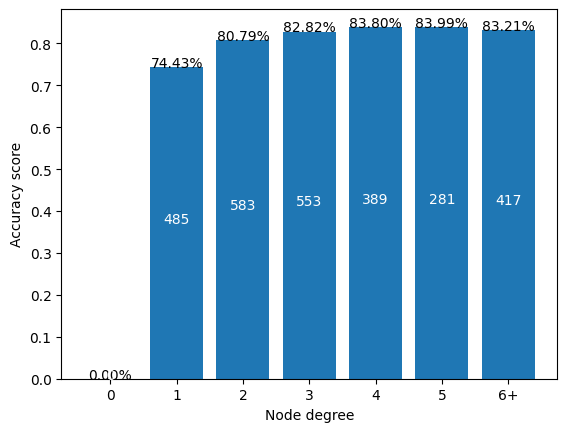

In [14]:
# Ensure you have imported required utilities
from torch_geometric.utils import degree
import matplotlib.pyplot as plt

# Use the Cora dataset and model
out = model_cora(data_cora.x, data_cora.edge_index)
degrees = degree(data_cora.edge_index[0]).numpy()

accuracies = []
sizes = []

for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    if len(mask) > 0:
        acc = (out.argmax(dim=1)[mask] == data_cora.y[mask]).sum().item() / len(mask)
        accuracies.append(acc)
        sizes.append(len(mask))
    else:
        accuracies.append(0)
        sizes.append(0)

mask = np.where(degrees > 5)[0]
if len(mask) > 0:
    acc = (out.argmax(dim=1)[mask] == data_cora.y[mask]).sum().item() / len(mask)
    accuracies.append(acc)
    sizes.append(len(mask))

# Plotting the bar chart
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0', '1', '2', '3', '4', '5', '6+'], accuracies)

for i in range(len(accuracies)):
    plt.text(i, accuracies[i], f'{accuracies[i] * 100:.2f}%', ha='center', color='black')
    plt.text(i, accuracies[i] / 2, sizes[i], ha='center', color='white')

plt.show()

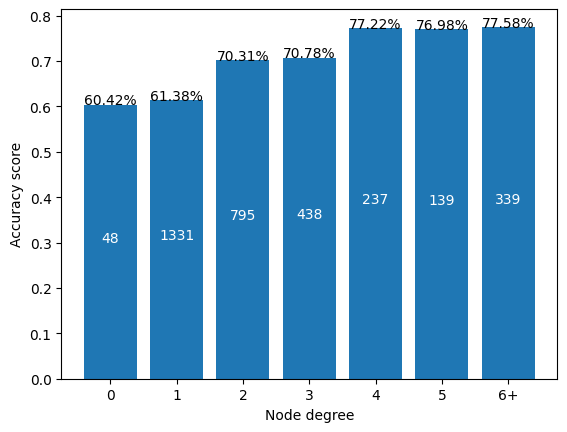

In [16]:
# Ensure you have imported required utilities
from torch_geometric.utils import degree
import matplotlib.pyplot as plt
import numpy as np

# Use the CiteSeer dataset and model
out = model_cs(data_cs.x, data_cs.edge_index)
degrees = degree(data_cs.edge_index[0]).numpy()

accuracies = []
sizes = []

for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    if len(mask) > 0:
        acc = (out.argmax(dim=1)[mask] == data_cs.y[mask]).sum().item() / len(mask)  # Fixed reference
        accuracies.append(acc)
        sizes.append(len(mask))
    else:
        accuracies.append(0)
        sizes.append(0)

mask = np.where(degrees > 5)[0]
if len(mask) > 0:
    acc = (out.argmax(dim=1)[mask] == data_cs.y[mask]).sum().item() / len(mask)  # Fixed reference
    accuracies.append(acc)
    sizes.append(len(mask))

# Plotting the bar chart
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0', '1', '2', '3', '4', '5', '6+'], accuracies)

for i in range(len(accuracies)):
    plt.text(i, accuracies[i], f'{accuracies[i] * 100:.2f}%', ha='center', color='black')
    plt.text(i, accuracies[i] / 2, sizes[i], ha='center', color='white')

plt.show()
